In [5]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation

plt.rcParams["animation.html"] = "jshtml"


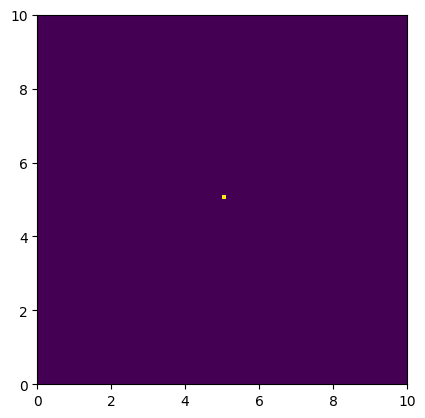

In [6]:
x = np.linspace(0, 10, 100)
X, Y = np.meshgrid(x, x)
Z = np.zeros_like(X)
Z[50, 50] = 1.0

plt.imshow(Z, origin="lower", extent=(0, 10, 0, 10))


In [26]:
def get_grad_x(Z):
    Z_mid = np.zeros_like(Z)
    Z_mid[1:-1, :] = (Z[:-2, :] - Z[2:, :]) / 2
    Z_mid[0, :] = Z[0, :] - Z[1, :]
    Z_mid[-1, :] = Z[-2, :] - Z[-1, :]
    return Z_mid


def get_grad_y(Z):
    Z_mid = np.zeros_like(Z)
    Z_mid[:, 1:-1] = (Z[:, :-2] - Z[:, 2:]) / 2
    Z_mid[:, 0] = Z[:, 0] - Z[:, 1]
    Z_mid[:, -1] = Z[:, -2] - Z[:, -1]
    return Z_mid


snapshots = []
Z_current = Z.copy()
for _ in range(20):
    dx = get_grad_x(Z)
    dy = get_grad_y(Z)
    d2x = get_grad_x(dx)
    d2y = get_grad_y(dy)
    Z_current = Z_current - 0.1 * (d2x + d2y)
    Z_current[50, 50] = Z_current[50, 50] + 1.0
    snapshots.append(Z_current.copy())

In [27]:
fig, ax = plt.subplots()


def show_it(i):
    ax.cla()
    ax.imshow(snapshots[i], origin="lower", extent=(0, 10, 0, 10))


anim = FuncAnimation(fig, show_it, frames=range(len(snapshots)))
plt.close()
anim


In [28]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation
import seaborn as sns

# Set up the grid
grid_size = 11
grid = np.zeros((grid_size, grid_size))

# Initial condition (e.g., a diffusing substance at the center)
grid[grid_size // 2, grid_size // 2] = 1.0

# Diffusion coefficient
D = 0.1

# Create the figure
fig, ax = plt.subplots()


# Function to update the animation
def update(frame):
    global grid
    new_grid = np.zeros_like(grid)
    # for i in range(1, grid_size - 1):
    #     for j in range(1, grid_size - 1):
    #         new_grid[i, j] = grid[i, j] + D * (
    #             grid[i - 1, j]
    #             + grid[i + 1, j]
    #             + grid[i, j - 1]
    #             + grid[i, j + 1]
    #             - 4 * grid[i, j]
    #         )
    new_grid[1:-1, 1:-1] = grid[1:-1, 1:-1] + D * (
        grid[:-2, 1:-1]
        + grid[2:, 1:-1]
        + grid[1:-1, :-2]
        + grid[1:-1, 2:]
        - 4 * grid[1:-1, 1:-1]
    )
    new_grid[grid_size // 2, grid_size // 2] += 1.0
    grid = new_grid
    ax.clear()
    # format annotations with 1 decimal place
    # sns.heatmap(grid, annot=True, ax=ax, cmap="RdYlGn_r", cbar=False, fmt=".1f")
    ax.imshow(grid, cmap="RdYlGn_r", interpolation="none")
    ax.set_title(f"Time Step: {frame * 0.1:.1f}")


fig.colorbar(ax.imshow(grid, cmap="RdYlGn_r"))

# Create the animation
ani = FuncAnimation(fig, update, frames=20, interval=100)
plt.close()
ani


In [31]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation

# Set up the grid
grid_size = 21
grid = np.zeros((grid_size, grid_size))

# Initial condition (e.g., a diffusing substance at the center)
grid[grid_size // 2, grid_size // 2] = 1.0

# Diffusion coefficient
D = 0.1

# Advection velocity field (you can modify this as needed)
Ux = 0.1
Uy = 0.1

# Create the figure
fig, ax = plt.subplots()

fig.colorbar(ax.imshow(grid, cmap="viridis", interpolation="none", vmin=0, vmax=0.5))


# Function to update the animation
def update(frame):
    global grid
    new_grid = grid.copy()

    # Calculate advection term
    adv_x = Ux * (grid[1:-1, 1:-1] - grid[1:-1, :-2])
    adv_y = Uy * (grid[1:-1, 1:-1] - grid[:-2, 1:-1])

    # Diffusion using vectorized operations, including edges
    diffusion = D * (
        grid[:-2, 1:-1]
        + grid[2:, 1:-1]
        + grid[1:-1, :-2]
        + grid[1:-1, 2:]
        - 4 * grid[1:-1, 1:-1]
    )

    # Update concentration with advection and diffusion
    new_grid[1:-1, 1:-1] = grid[1:-1, 1:-1] + adv_x + adv_y + diffusion
    # new_grid[grid_size // 2, grid_size // 2] += 1.0
    # Handle edges using periodic boundary conditions
    # new_grid[0, :] = new_grid[-1, :] = new_grid[:, 0] = new_grid[:, -1] = new_grid[
    #     1:-1, 1:-1
    # ]

    grid = new_grid
    ax.clear()
    ax.imshow(grid, cmap="viridis", interpolation="none", vmin=0, vmax=0.5)
    ax.set_title(f"Time Step: {frame * 0.1:.1f}")


# Create the animation
ani = FuncAnimation(fig, update, frames=20, interval=100)
plt.close()
ani


In [2]:
from sklearn.metrics import mean_absolute_percentage_error

In [3]:
from aqmsp_data.data import load_caaqm, load_camx


In [9]:
MAPEs = []
months = list(range(1, 13))
for month in months:
    caaqm = load_caaqm(years=2022, months=month, variables="PM2.5")
    camx = load_camx(years=2022, months=month, variables="P25")
    station_pm = caaqm["PM2.5"].mean(dim="station").values
    camx_pm = camx["P25"].mean(dim=["latitude", "longitude"]).values
    print(station_pm.shape, camx_pm.shape)

    is_nan = np.isnan(station_pm) | np.isnan(camx_pm)
    station_pm = station_pm[~is_nan]
    camx_pm = camx_pm[~is_nan]
    # station_pm[station_pm < 1.0] = 1.0
    print(station_pm.shape, camx_pm.shape)

    mape = mean_absolute_percentage_error(station_pm, camx_pm)
    MAPEs.append(mape)


/home/patel_zeel/miniconda3/lib/python3.9/site-packages/xarray/core/indexing.py:1443: PerformanceWarning: Slicing is producing a large chunk. To accept the large
chunk and silence this warning, set the option
    >>> with dask.config.set(**{'array.slicing.split_large_chunks': False}):
    ...     array[indexer]

To avoid creating the large chunks, set the option
    >>> with dask.config.set(**{'array.slicing.split_large_chunks': True}):
    ...     array[indexer]
  return self.array[key]


(744,) (744,)
(744,) (744,)


/home/patel_zeel/miniconda3/lib/python3.9/site-packages/xarray/core/indexing.py:1443: PerformanceWarning: Slicing is producing a large chunk. To accept the large
chunk and silence this warning, set the option
    >>> with dask.config.set(**{'array.slicing.split_large_chunks': False}):
    ...     array[indexer]

To avoid creating the large chunks, set the option
    >>> with dask.config.set(**{'array.slicing.split_large_chunks': True}):
    ...     array[indexer]
  return self.array[key]


(672,) (672,)
(672,) (672,)


/home/patel_zeel/miniconda3/lib/python3.9/site-packages/xarray/core/indexing.py:1443: PerformanceWarning: Slicing is producing a large chunk. To accept the large
chunk and silence this warning, set the option
    >>> with dask.config.set(**{'array.slicing.split_large_chunks': False}):
    ...     array[indexer]

To avoid creating the large chunks, set the option
    >>> with dask.config.set(**{'array.slicing.split_large_chunks': True}):
    ...     array[indexer]
  return self.array[key]


(744,) (744,)
(696,) (696,)


/home/patel_zeel/miniconda3/lib/python3.9/site-packages/xarray/core/indexing.py:1443: PerformanceWarning: Slicing is producing a large chunk. To accept the large
chunk and silence this warning, set the option
    >>> with dask.config.set(**{'array.slicing.split_large_chunks': False}):
    ...     array[indexer]

To avoid creating the large chunks, set the option
    >>> with dask.config.set(**{'array.slicing.split_large_chunks': True}):
    ...     array[indexer]
  return self.array[key]


(720,) (720,)
(720,) (720,)


/home/patel_zeel/miniconda3/lib/python3.9/site-packages/xarray/core/indexing.py:1443: PerformanceWarning: Slicing is producing a large chunk. To accept the large
chunk and silence this warning, set the option
    >>> with dask.config.set(**{'array.slicing.split_large_chunks': False}):
    ...     array[indexer]

To avoid creating the large chunks, set the option
    >>> with dask.config.set(**{'array.slicing.split_large_chunks': True}):
    ...     array[indexer]
  return self.array[key]


(744,) (744,)
(744,) (744,)


/home/patel_zeel/miniconda3/lib/python3.9/site-packages/xarray/core/indexing.py:1443: PerformanceWarning: Slicing is producing a large chunk. To accept the large
chunk and silence this warning, set the option
    >>> with dask.config.set(**{'array.slicing.split_large_chunks': False}):
    ...     array[indexer]

To avoid creating the large chunks, set the option
    >>> with dask.config.set(**{'array.slicing.split_large_chunks': True}):
    ...     array[indexer]
  return self.array[key]


(720,) (720,)
(720,) (720,)


/home/patel_zeel/miniconda3/lib/python3.9/site-packages/xarray/core/indexing.py:1443: PerformanceWarning: Slicing is producing a large chunk. To accept the large
chunk and silence this warning, set the option
    >>> with dask.config.set(**{'array.slicing.split_large_chunks': False}):
    ...     array[indexer]

To avoid creating the large chunks, set the option
    >>> with dask.config.set(**{'array.slicing.split_large_chunks': True}):
    ...     array[indexer]
  return self.array[key]


(744,) (744,)
(672,) (672,)


/home/patel_zeel/miniconda3/lib/python3.9/site-packages/xarray/core/indexing.py:1443: PerformanceWarning: Slicing is producing a large chunk. To accept the large
chunk and silence this warning, set the option
    >>> with dask.config.set(**{'array.slicing.split_large_chunks': False}):
    ...     array[indexer]

To avoid creating the large chunks, set the option
    >>> with dask.config.set(**{'array.slicing.split_large_chunks': True}):
    ...     array[indexer]
  return self.array[key]


(744,) (744,)
(744,) (744,)


/home/patel_zeel/miniconda3/lib/python3.9/site-packages/xarray/core/indexing.py:1443: PerformanceWarning: Slicing is producing a large chunk. To accept the large
chunk and silence this warning, set the option
    >>> with dask.config.set(**{'array.slicing.split_large_chunks': False}):
    ...     array[indexer]

To avoid creating the large chunks, set the option
    >>> with dask.config.set(**{'array.slicing.split_large_chunks': True}):
    ...     array[indexer]
  return self.array[key]


(720,) (720,)
(720,) (720,)


/home/patel_zeel/miniconda3/lib/python3.9/site-packages/xarray/core/indexing.py:1443: PerformanceWarning: Slicing is producing a large chunk. To accept the large
chunk and silence this warning, set the option
    >>> with dask.config.set(**{'array.slicing.split_large_chunks': False}):
    ...     array[indexer]

To avoid creating the large chunks, set the option
    >>> with dask.config.set(**{'array.slicing.split_large_chunks': True}):
    ...     array[indexer]
  return self.array[key]


(744,) (744,)
(744,) (744,)


/home/patel_zeel/miniconda3/lib/python3.9/site-packages/xarray/core/indexing.py:1443: PerformanceWarning: Slicing is producing a large chunk. To accept the large
chunk and silence this warning, set the option
    >>> with dask.config.set(**{'array.slicing.split_large_chunks': False}):
    ...     array[indexer]

To avoid creating the large chunks, set the option
    >>> with dask.config.set(**{'array.slicing.split_large_chunks': True}):
    ...     array[indexer]
  return self.array[key]


(720,) (720,)
(720,) (720,)


/home/patel_zeel/miniconda3/lib/python3.9/site-packages/xarray/core/indexing.py:1443: PerformanceWarning: Slicing is producing a large chunk. To accept the large
chunk and silence this warning, set the option
    >>> with dask.config.set(**{'array.slicing.split_large_chunks': False}):
    ...     array[indexer]

To avoid creating the large chunks, set the option
    >>> with dask.config.set(**{'array.slicing.split_large_chunks': True}):
    ...     array[indexer]
  return self.array[key]


(744,) (744,)
(581,) (581,)


Text(0.5, 1.0, 'MAPE of CAMx vs CAAQM PM2.5 (2022)')

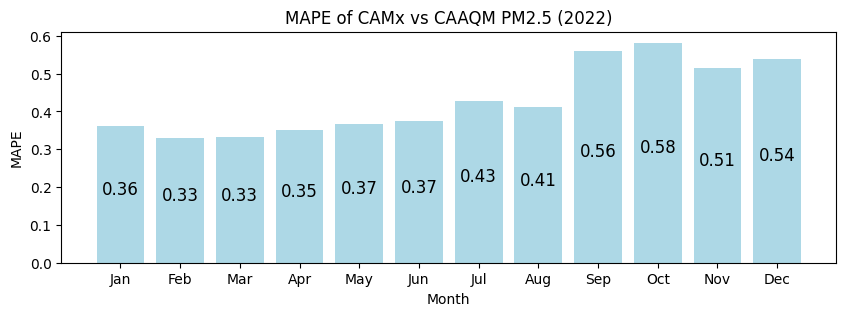

In [28]:
import calendar

plt.figure(figsize=(10, 3))
plt.bar(months, MAPEs, color="lightblue")
# set month names as xticklabels
plt.xticks(months, [calendar.month_abbr[m] for m in months])
# annotate each bar with its value (rounded to 2 decimal places). Value should appear inside the bar in the center. Set font size to 12.
for i, mape in enumerate(MAPEs):
    plt.annotate(f"{mape:.2f}", (months[i], MAPEs[i] / 2), ha="center", fontsize=12)
plt.xlabel("Month")
plt.ylabel("MAPE")
plt.title("MAPE of CAMx vs CAAQM PM2.5 (2022)")

In [1]:
# plt.imread(r"https://raw.githubusercontent.com/AYUSHs799/SpiroMask_DIY/main/intro.jpg")

import torch
import torch.nn as nn

a = torch.tensor([1, 2, 3])
locals()["a"] = locals()["a"].to("cuda")
print(a.device)

cuda:0
